In [4]:
# from astroquery.gaia import Gaia
# from astropy.table import Table, vstack
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib import colors

# # Simplified query template for debugging
# query_template_simple = """
# SELECT
#     TOP 10000
#     source_id,
#     parallax,
#     ra,
#     dec
# FROM
#     gaiaedr3.gaia_source
# WHERE
#     parallax_over_error > 10
#     AND ra BETWEEN {ra_min} AND {ra_max}
# """

# def execute_query_simple(ra_min, ra_max):
#     query = query_template_simple.format(ra_min=ra_min, ra_max=ra_max)
#     print(query)  # Print query for debugging
#     job = Gaia.launch_job(query)
#     return job.get_results()

# # Define a small RA range for testing
# ra_ranges_test = [(0, 10)]

# # Execute queries and combine results
# results = []
# for ra_min, ra_max in ra_ranges_test:
#     result = execute_query_simple(ra_min, ra_max)
#     results.append(result)

# # Combine all results into a single table
# data = vstack(results)

# # Check the results
# print(data)


SELECT
    TOP 10000
    source_id,
    parallax,
    ra,
    dec
FROM
    gaiaedr3.gaia_source
WHERE
    parallax_over_error > 10
    AND ra BETWEEN 0 AND 10

     source_id           parallax                ra                   dec        
                           mas                  deg                   deg        
------------------- ------------------ ---------------------- -------------------
2882189828921792896 0.5596216518148802 1.5207137117992139e-06   40.69004652963738
2746667873972721536 2.0921455152688226 1.6327128351173464e-06   7.754647322337991
1993615693009816064 0.9313635960448875 1.0507620141516412e-05  54.656342485023565
 429483917726497152   0.69248850864397  2.478361123902537e-05  61.203134672562456
 430084354157207680 0.6849459626180749 4.4804542391425535e-05  63.191973078527774
 423186567953698048 1.5681671132433475   4.75324154342406e-05  59.377921891726736
                ...                ...                    ...                 ...
2873828558388015232

In [11]:
from astroquery.gaia import Gaia
from astropy.table import Table, vstack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Template for the query with placeholders for RA ranges
query_template = """
SELECT
    source_id,
    parallax,
    phot_g_mean_mag AS mg,
    phot_g_mean_flux_error AS mg_error,
    phot_bp_mean_mag AS mbp,
    phot_bp_mean_flux_error AS mbp_error,
    phot_rp_mean_mag AS mrp,
    phot_rp_mean_flux_error AS mrp_error,
    bp_rp,
    phot_g_mean_flux,
    phot_bp_mean_flux,
    phot_rp_mean_flux
FROM
    gaiaedr3.gaia_source
WHERE
    parallax_over_error > 10
    AND phot_g_mean_flux_over_error > 50
    AND phot_rp_mean_flux_over_error > 20
    AND phot_bp_mean_flux_over_error > 20
    AND phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(bp_rp, 2)
    AND phot_bp_rp_excess_factor > 1.0 + 0.015 * POWER(bp_rp, 2)
    AND bp_rp IS NOT NULL
    AND phot_bp_mean_mag IS NOT NULL
    AND phot_rp_mean_mag IS NOT NULL
    AND dec > 0
    AND ra BETWEEN {ra_min} AND {ra_max}
    AND parallax >= 2.5
"""

# Function to execute a query for a given RA range
def execute_query(ra_min, ra_max):
    query = query_template.format(ra_min=ra_min, ra_max=ra_max)
    job = Gaia.launch_job_async(query)
    return job.get_results()

# Define RA ranges to split the query
ra_ranges = [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)]

# Execute queries and combine results
results = []
for ra_min, ra_max in ra_ranges:
    result = execute_query(ra_min, ra_max)
    results.append(result)

# Combine all results into a single table
data = vstack(results)

INFO: Query finished. [astroquery.utils.tap.core]


KeyboardInterrupt: 

In [ ]:
data

In [ ]:
data.colnames

In [ ]:
# Correct for extinction
mg_corrected = data['mg']# - data['ag_gspphot']
mbp_corrected = data['mbp']# - data['ag_gspphot']
mrp_corrected = data['mrp']# - data['ag_gspphot']

# Compute an approximate combined absolute magnitude
# combined_magnitude = (mg_corrected + mbp_corrected + mrp_corrected) / 3
# combined_magnitude = (mg_corrected)
combined_magnitude = (mbp_corrected + mrp_corrected)

# Filter stars based on the combined absolute magnitude
# bright_stars = data[combined_magnitude < 5]
bright_stars = data # Already choosen

# Extract corrected magnitudes and colors for plotting
mg_corrected = bright_stars['mg']# - bright_stars['ag_gspphot']
bp_rp_corrected = bright_stars['bp_rp']# - bright_stars['ebpminrp_gspphot']
gaia_ids = bright_stars['source_id']
RA = bright_stars['ra']
DEC = bright_stars['dec']
PRA = bright_stars['pmra']
PDEC = bright_stars['pmdec']

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors

# Create a 2D histogram (heatmap) for density
plt.figure(figsize=(10, 10))
hb = plt.hexbin(bp_rp_corrected, mg_corrected, gridsize=500, cmap='inferno', bins='log', mincnt=1)
plt.colorbar(hb, label='Density')

# Plot the data points
plt.scatter(bp_rp_corrected, mg_corrected, alpha=0.05, s=1, color='w', zorder=0)

# Customize the plot
plt.gca().invert_yaxis()
plt.xlabel('BP-RP Color (mag)')
plt.ylabel('Absolute Magnitude (G-band)')
plt.title('Hertzsprung-Russell Diagram')

# Get the current Axes object before showing the plot
ax = plt.gca()
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()

plt.show()

In [ ]:
%pwd
%cd "/home/dutta/Downloads/Summer'24"

In [102]:
# import astropy.table as tbl
# import numpy as np

# data_path = "unique_df.txt"
# txt_data = np.loadtxt(data_path, skiprows=1, delimiter="\t", usecols=(1, 8, 2, 4, 6))

# # print(len(txt_data[0]))

# # Convert the loaded data into an astropy.table.Table for easier handling
# txt_data_table = tbl.Table(txt_data, names=["Gaia_ID", "mg", "bp", "rp", "bp_rp"])

# # Access the Gaia_ID column from the data table
# data_source_ids = data["source_id"]

# # Print column headers
# print("{:<20} {:<10} {:<10}".format("Gaia_ID", "Data", "txt"))

# # Loop through each Gaia_ID in the txt_data_table
# for i, row in enumerate(txt_data_table):
#   gaia_id = row["Gaia_ID"]

#   # Check if the Gaia_ID exists in the data table
#   if gaia_id in data_source_ids:
#     # Get the corresponding index of the Gaia_ID in the data table
#     data_index = np.where(data_source_ids == gaia_id)[0][0]

#     # Extract values from both tables
#     data_mg = data["mg"][data_index]
#     data_bp = data["mbp"][data_index]
#     data_rp = data["mrp"][data_index]
#     data_bp_rp = data["bp_rp"][data_index]

#     txt_mg = row["mg"]
#     txt_bp = row["bp"]
#     txt_rp = row["rp"]
#     txt_bp_rp = row["bp_rp"]

#     # Print data side-by-side
#     print("{} {:<10.4f} {:<10.4f}".format(gaia_id, data_mg, txt_mg))
#     print("{:<20} {:<10.4f} {:<10.4f}".format("", data_bp, txt_bp))
#     print("{:<20} {:<10.4f} {:<10.4f}".format("", data_rp, txt_rp))
#     print("{:<20} {:<10.4f} {:<10.4f}".format("", data_bp_rp, txt_bp_rp))
#     print("-"*40)
#   else:
#     print(f"Gaia_ID: {gaia_id} not found in data table")
#     print("-"*40)

In [103]:
import astropy.table as tbl
import numpy as np
import pandas as pd

data_path = "unique_df.txt"
txt_data = np.loadtxt(data_path, skiprows=1, delimiter="\t", usecols=(1, 8, 2, 4, 6), dtype=str)

# Convert loaded data into astropy.table.Table
txt_data_table = tbl.Table(txt_data, names=["Gaia_ID", "mg", "bp", "rp", "bp_rp"])

# Assume 'data' is a Pandas DataFrame with 'source_id' column (modify if structure differs)
data_source_ids = data["source_id"]
# print(type(data_source_ids[0]))

# Create empty lists to store data
gaia_ids, data_mg, data_bp, data_rp, data_bp_rp, txt_mg, txt_bp, txt_rp, txt_bp_rp = [], [], [], [], [], [], [], [], []

# Loop through each Gaia_ID in txt_data_table
for i, row in enumerate(txt_data_table):
    gaia_id = np.int64(row["Gaia_ID"])
    # print(type(gaia_id))
    # print(1)

    if gaia_id in data_source_ids:
        # Get corresponding index
        data_index = np.where(data_source_ids == gaia_id)[0][0]
        # print(gaia_id)

        # Extract values from both tables
        data_mg.append(data["mg"][data_index])
        data_bp.append(data["mbp"][data_index])  # Assuming 'mbp' column exists
        data_rp.append(data["mrp"][data_index])  # Assuming 'mrp' column exists
        data_bp_rp.append(data["bp_rp"][data_index])

        txt_mg.append(row["mg"])
        txt_bp.append(row["bp"])
        txt_rp.append(row["rp"])
        txt_bp_rp.append(row["bp_rp"])
        gaia_ids.append(gaia_id)

# # Check for list length discrepancies (optional)
# print(f"Length of Gaia_IDs: {len(gaia_ids)}")
# print(f"Length of data_mg: {len(data_bp)}")
# Print similar messages for other lists

# print(len(data_bp), len(txt_bp), len(data_bp_rp))

# Handle missing values (if necessary)
# Option 1: Fill with a default value (e.g., np.nan)
# Option 2: Filter data based on the shortest list (example using data_mg)
# if len(gaia_ids) != len(data_mg):
#     common_indices = [i for i, _ in enumerate(gaia_ids) if gaia_ids[i] in data_source_ids]
#     gaia_ids = [gaia_ids[i] for i in common_indices]
#     data_mg = [data_mg[i] for i in common_indices]
#     # Repeat for other lists

# Create the Pandas DataFrame
df = pd.DataFrame({
    "Gaia_ID": gaia_ids,
    "Data_mg": data_mg,
    "Text_mg": txt_mg,
    "Data_bp": data_bp,
    "Text_bp": txt_bp,
    "Data_rp": data_rp,
    "Text_rp": txt_rp,
    "Data_bp_rp": data_bp_rp,
    "Text_bp_rp": txt_bp_rp
})

In [104]:
df

,Gaia_ID,Data_mg,Text_mg,Data_bp,Text_bp,Data_rp,Text_rp,Data_bp_rp,Text_bp_rp
0,100132734395672832,6.361703,7.485276699066162,6.782729,6.737506866455078,5.761780,5.716556549072266,1.020949,1.0209503173828125
1,258694062155646464,7.735897,9.63378620147705,8.458402,8.526578903198242,6.759784,6.827959060668945,1.698617,1.6986198425292969
2,264403826035674240,6.356807,7.545171737670898,6.801934,6.68239688873291,5.743402,5.623867034912109,1.058532,1.0585298538208008
3,366461560476811264,6.050480,7.255118370056152,6.503023,6.408851623535156,5.425721,5.331551551818848,1.077302,1.0773000717163086
4,421737274187773824,6.510629,7.511810302734375,6.965806,6.874336242675781,5.854147,5.762676239013672,1.111659,1.1116600036621094
5,426676142984247808,6.190470,6.189882278442383,6.663086,6.726387023925781,5.546093,5.6093974113464355,1.116993,1.1169896125793457
6,432276161856742016,6.927909,8.432748794555664,7.469677,7.5576348304748535,6.227832,6.315794944763184,1.241845,1.24183988571167
7,571348130611591296,5.390020,6.645877838134766,5.831440,5.8290486335754395,4.789998,4.7876081466674805,1.041442,1.041440486907959
8,656549321007564800,5.785110,7.1608967781066895,6.255035,6.27240514755249,5.146242,5.1636152267456055,1.108793,1.1087899208068848
9,662794169095142912,6.415675,7.344702243804932,6.753031,6.630257606506348,5.903957,5.78118371963501,0.849074,0.8490738868713379


In [105]:
# Save the DataFrame to a .txt file
df.to_csv('df.csv', sep='\t', index=False)

In [2]:
%pwd

"/home/dutta/Downloads/Summer'24"

                    0         1         2         3         4         5  \
0  100132734395672832  6.361703  7.485277  6.782729  6.737507  5.761780   
1  258694062155646464  7.735897  9.633786  8.458402  8.526579  6.759784   
2  264403826035674240  6.356807  7.545172  6.801934  6.682397  5.743402   
3  366461560476811264  6.050480  7.255118  6.503023  6.408852  5.425721   
4  421737274187773824  6.510629  7.511810  6.965806  6.874336  5.854147   

          6         7        8  
0  5.716557  1.020949  1.02095  
1  6.827959  1.698617  1.69862  
2  5.623867  1.058532  1.05853  
3  5.331552  1.077303  1.07730  
4  5.762676  1.111659  1.11166  


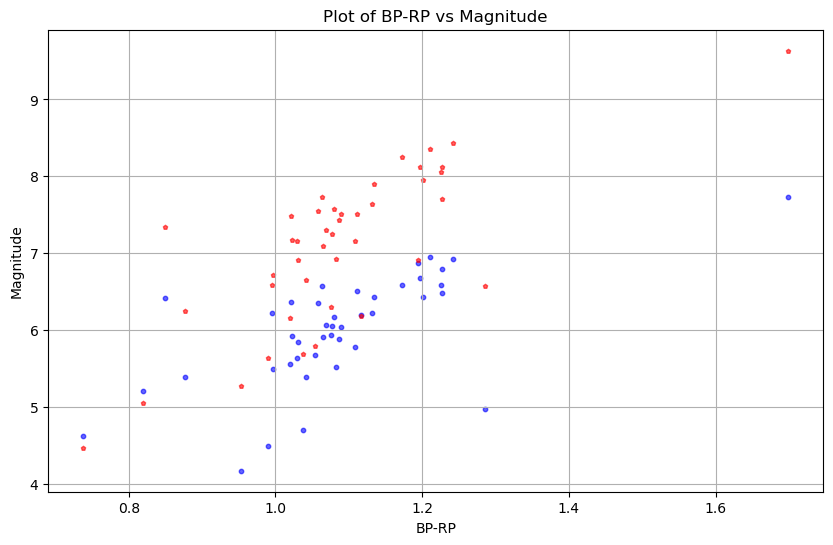

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "df.csv"
df = pd.read_csv(file_path, delimiter='\t', header=None)

# Remove the first row (header row)
df = df.iloc[1:].reset_index(drop=True)

# Convert columns to appropriate data types
df = df.apply(pd.to_numeric, errors='coerce')

# Display the first few rows of the DataFrame to confirm the data
print(df.head())

# Assuming you want to plot the first two columns
column1 = df[7]
column2 = df[1]

column3 = df[8]
column4 = df[2]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.scatter(column1, column2, marker='o', color='b', alpha=0.6, s=10)
plt.scatter(column3, column4, marker='p', color='r', alpha=0.6, s=10)
plt.title('Plot of BP-RP vs Magnitude')
plt.xlabel('BP-RP')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

In [5]:
import numpy as np

# Taken from Random 3
T = np.array([[ 1.,    0.  ],
             [-0.76,  1.  ]])

Transformation Matrix (T):
[[ 1.    0.  ]
 [-0.76  1.  ]]
Converted Points on line1:
[[1.02095032 1.69861984 1.05852985 1.07730007 1.11166    1.11698961
  1.24183989 1.04144049 1.10878992 0.84907389 1.07986975 1.08669043
  0.99033594 1.03103018 1.13398027 1.19707012 0.99545813 1.13146973
  1.28563976 1.02203989 0.99701405 1.17292023 1.06832981 1.07616997
  0.95359468 1.06375027 0.81947517 1.02013016 1.06455994 1.22527027
  0.87703657 1.02930975 1.08274984 1.03816986 1.20109987 1.05381012
  1.22707987 0.738204   1.22643948 1.1949501  1.21043015 1.08995962]
 [6.70935446 8.34283512 6.74068905 6.43637032 6.6669487  5.34097017
  7.48895048 5.85438307 6.31821644 6.69940609 6.75131952 6.60042868
  4.88371153 6.13415216 7.03734491 7.21775585 5.82435535 6.78086155
  5.59929832 6.39589668 5.95612411 7.35525135 6.48581362 5.48916677
  4.55097719 6.91645672 4.42388075 5.37593571 6.28615883 7.12461506
  5.58784388 6.37699297 6.10616343 4.90429258 7.03591173 4.9861989
  6.77584482 3.90979874 7.18908

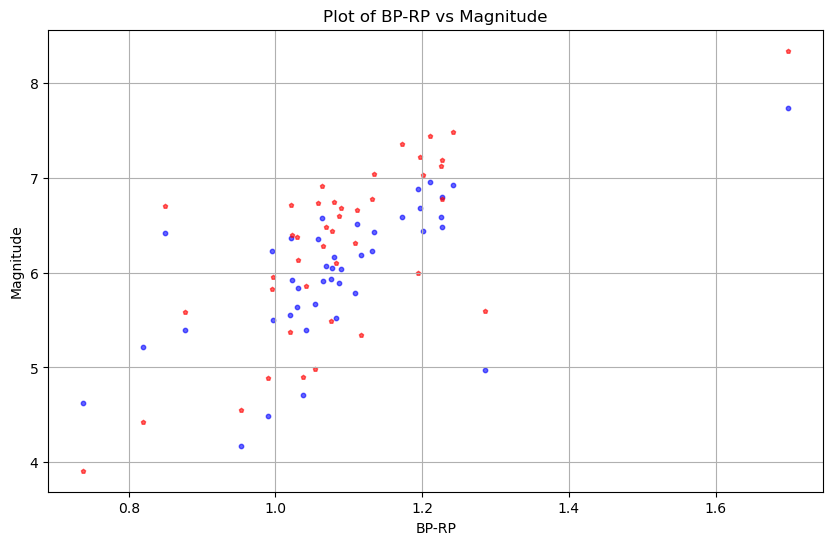

In [6]:
# Define arrays of x and y coordinates for the points on line2
x_points = column3
y_points = column4

# Construct a 2D array representing the points on line2
points_on_line2 = np.vstack((x_points, y_points))

# Convert the points using the transformation matrix
converted_points = T @ points_on_line2

# Print the transformation matrix
print("Transformation Matrix (T):")
print(T)

# Print the converted points
print("Converted Points on line1:")
print(converted_points)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.scatter(column1, column2, marker='o', color='b', alpha=0.6, s=10)
plt.scatter(converted_points[0], converted_points[1], marker='p', color='r', alpha=0.6, s=10)
plt.title('Plot of BP-RP vs Magnitude')
plt.xlabel('BP-RP')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

In [9]:
# import numpy as np
# import pandas as pd
# from scipy.stats import t
# from statsmodels.multivariate.manova import MANOVA

# # Example data
# x1 = column1
# y1 = column2
# x2 = converted_points[0]
# y2 = converted_points[1]
# # x2 = column3
# # y2 = column4

# # Combine data into a single DataFrame
# data = pd.DataFrame({
#     'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2
# })

# # Calculate differences
# data['dx'] = data['x2'] - data['x1']
# data['dy'] = data['y2'] - data['y1']

# # Perform Hotelling's T-squared test
# m = MANOVA.from_formula('dx + dy ~ 1', data=data)
# print(m.mv_test())

# # Calculate Hotelling's T-squared statistic
# mean_deltas = np.array([data['dx'].mean(), data['dy'].mean()])
# cov_deltas = np.cov(data[['dx', 'dy']], rowvar=False)
# inv_cov_deltas = np.linalg.inv(cov_deltas)
# t_squared = mean_deltas.T @ inv_cov_deltas @ mean_deltas

# # Calculate F-statistic and p-value
# n = len(data)
# p = 2  # number of variables (dx and dy)
# f_stat = (n - p) / (p * (n - 1)) * t_squared
# p_value = 1 - t.cdf(f_stat, df=n-p)

# print(f"Hotelling's T-squared statistic: {t_squared}")
# print(f"F-statistic: {f_stat}")
# print(f"P-value: {p_value}")

# # Check if movement is significant with 95% confidence
# alpha = 0.05
# if p_value < alpha:
#     print("Significant movement detected with 95% confidence.")
# else:
#     print("No significant movement detected with 95% confidence.")

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.7257 2.0000 40.0000  7.5604 0.0016
         Pillai's trace 0.2743 2.0000 40.0000  7.5604 0.0016
 Hotelling-Lawley trace 0.3780 2.0000 40.0000  7.5604 0.0016
    Roy's greatest root 0.3780 2.0000 40.0000  7.5604 0.0016

Hotelling's T-squared statistic: 0.36901900906712387
F-statistic: 0.1800092727156702
P-value: 0.42902707317065203
No significant movement detected with 95% confidence.


In [12]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import chi2

# Example data with errors
x1 = np.array([1.0, 2.0, 3.0])
y1 = np.array([1.0, 2.0, 3.0])
x1_err = np.array([0.1, 0.1, 0.1])
y1_err = np.array([0.1, 0.1, 0.1])

x2 = np.array([1.1, 2.2, 3.3])
y2 = np.array([1.1, 2.2, 3.3])
x2_err = np.array([0.1, 0.1, 0.1])
y2_err = np.array([0.1, 0.1, 0.1])

# Combine data into a single DataFrame
data = pd.DataFrame({
    'x1': x1, 'y1': y1, 'x1_err': x1_err, 'y1_err': y1_err,
    'x2': x2, 'y2': y2, 'x2_err': x2_err, 'y2_err': y2_err
})

# Calculate differences and errors
data['dx'] = data['x2'] - data['x1']
data['dy'] = data['y2'] - data['y1']
data['dx_err'] = np.sqrt(data['x1_err']**2 + data['x2_err']**2)
data['dy_err'] = np.sqrt(data['y1_err']**2 + data['y2_err']**2)

# Log-Likelihood function for errors-in-variables model
def log_likelihood(params, dx, dy, dx_err, dy_err):
    mu_dx, mu_dy = params
    residuals_dx = (dx - mu_dx) / dx_err
    residuals_dy = (dy - mu_dy) / dy_err
    log_like = -0.5 * (np.sum(residuals_dx**2) + np.sum(residuals_dy**2))
    return -log_like  # negative log-likelihood for minimization

# Initial guess for the parameters
initial_guess = [0, 0]

# Minimize the negative log-likelihood
result = minimize(log_likelihood, initial_guess, args=(data['dx'], data['dy'], data['dx_err'], data['dy_err']))
mu_dx_hat, mu_dy_hat = result.x

# Compute the chi-square statistic
chi2_stat = -2 * result.fun
df = 2  # degrees of freedom
p_value = 1 - chi2.cdf(chi2_stat, df)

print(f"Estimated dx: {mu_dx_hat}, Estimated dy: {mu_dy_hat}")
print(f"Chi-square statistic: {chi2_stat}, P-value: {p_value}")

# Check if movement is significant with 95% confidence
alpha = 0.05
if p_value < alpha:
    print("Significant movement detected with 95% confidence.")
else:
    print("No significant movement detected with 95% confidence.")

Estimated dx: 0.1999999991142583, Estimated dy: 0.1999999991142583
Chi-square statistic: -1.9999999999999942, P-value: 1.0
No significant movement detected with 95% confidence.
